Install MMSegmentation

https://github.com/open-mmlab/mmsegmentation/blob/main/docs/en/get_started.md#installation

Showing the original image example

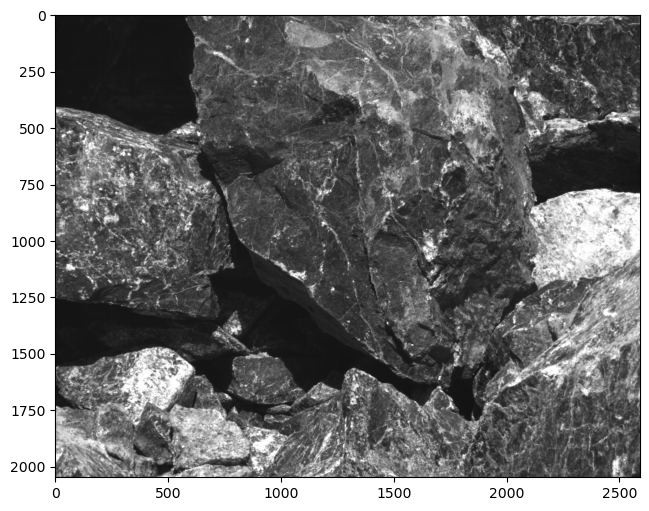

In [5]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt

test_image = '14-40-42_11_2_9'


img = mmcv.imread('asbestos/images/'+test_image+'.bmp')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Loading the dataset

In [6]:
from asbestos import AsbestosDataset

data_root = 'asbestos'
img_dir = 'images'
ann_dir = 'labels'
# define class and palette for better visualization
#classes = ('asbestos', 'stone', 'background')
#palette = [[146, 17, 162], [112, 128, 0], [0, 0, 0]]

#classes = ('background', 'stone', 'asbestos')
#palette = [[15,15,15],[112, 128, 0],[146, 17, 162]]

#classes = ('background', 'asbestos')
#palette = [[15, 15, 15], [146, 17, 162]]

classes = ('background', 'stone', 'asbestos')
palette = [[15,15,15],[112, 128, 0],[146, 17, 162]]

In [7]:
import os.path as osp
import numpy as np
from PIL import Image

# convert dataset annotation to semantic segmentation map
#for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
#  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#  seg_img = Image.fromarray(seg_map).convert('P')
#  seg_img.putpalette(np.array(palette, dtype=np.uint8))
#  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
#                                                         '.png')))

Show the segmentation map for test image

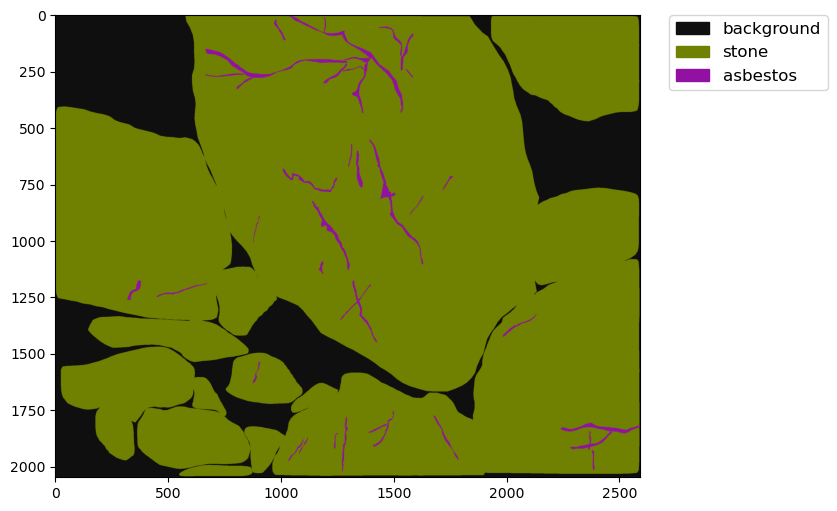

In [8]:
import matplotlib.patches as mpatches
img = Image.open('asbestos/labels/'+test_image+'.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(palette))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

Splitting the dataset into a train and validation subsets

In [ ]:
import random

# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

random.shuffle(filename_list)

# select first 4/5 as train set
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])

# select last 1/5 as train set
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list[train_length:])

Downloading the model and loading the config

In [9]:
!mim download mmsegmentation --config segformer_mit-b4_8xb1-160k_cityscapes-1024x1024 --dest .

processing segformer_mit-b4_8xb1-160k_cityscapes-1024x1024...
segformer_mit-b4_8x1_1024x1024_160k_cityscapes_20211207_080709-07f6c333.pth exists in D:\work15\mmseg_veins
Successfully dumped segformer_mit-b4_8xb1-160k_cityscapes-1024x1024.py to D:\work15\mmseg_veins


In [10]:
from mmengine import Config

cfg = Config.fromfile('segformer_mit-b4_8xb1-160k_cityscapes-1024x1024.py')

print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(1024, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(1024, 1024)),
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 8, 27, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict

Modifying the config

In [12]:
cfg.workflow = [('train', 1), ('val', 1)]

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (1024, 1024)
cfg.model.data_preprocessor.size = cfg.crop_size
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 3

#cfg.model.decode_head.loss_cls=dict(
#            type='mmdet.CrossEntropyLoss',
#            use_sigmoid=False,
#            loss_weight=2.0,
#            reduction='mean',
#            class_weight=[
#                1.0, 1.0, 1.0
#            ])

cfg.model.decode_head.loss_decode=[
        dict(type='CrossEntropyLoss', use_sigmoid=False, loss_name='loss_ce', loss_weight=1.0, class_weight=[1.0, 1.0, 55.0], avg_non_ignore=True),
        dict(type='DiceLoss', loss_name='loss_dice', loss_weight=3.0)
    ]

#dict(
    #type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[1.0, 10.0, 50.0])

#cfg.model.decode_head.loss_decode=dict(
#    type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0, class_weight=[1.0, 2.0, 10.0])
                                                                            #[0.1, 1.0, 10.0])    
#cfg.model.auxiliary_head.loss_decode=dict(
#    type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4, class_weight=[1.0, 1.0, 10.0])
#cfg.model.decode_head.threshold = 0.50
#cfg.model.auxiliary_head.num_classes = 3

# Modify dataset type and path
cfg.dataset_type = 'AsbestosDataset'
cfg.data_root = data_root
#cfg.reduce_zero_label=True
#cfg.class_weight = [1.0, 10.0]

#cfg.train_dataloader.batch_size = 4
#cfg.train_dataloader.num_workers = 4

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(2592, 2048), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(2592, 2048), keep_ratio=True),
#    # dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

#cfg.val_dataloader.num_workers = cfg.train_dataloader.num_workers
cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader
cfg.test_dataloader.num_workers = cfg.train_dataloader.num_workers

# Load the pretrained weights
cfg.load_from = 'segformer_mit-b4_8x1_1024x1024_160k_cityscapes_20211207_080709-07f6c333.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs_segformer/test'

cfg.train_cfg.max_iters = 16000
cfg.train_cfg.val_interval = 1000
cfg.default_hooks.logger.interval = 100
cfg.default_hooks.checkpoint.interval = 1000


cfg.val_evaluator = dict(ignore_index=0, type='IoUMetric', iou_metrics=['mIoU', 'mDice', 'mFscore'])
cfg.test_evaluator  = dict(ignore_index=0, type='IoUMetric', iou_metrics=['mIoU', 'mDice', 'mFscore'])

# Set seed to facilitate reproducing the result
# cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(1024, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(1024, 1024)),
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 8, 27, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(
  

Train

In [13]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

12/06 06:53:53 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: win32
    Python: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
    CUDA available: True
    numpy_random_seed: 563536689
    GPU 0: NVIDIA GeForce RTX 4090
    CUDA_HOME: D:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    MSVC: n/a, reason: fileno
    PyTorch: 1.13.0
    PyTorch compiling details: PyTorch built with:
  - C++ Version: 199711
  - MSVC 192829337
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-ge

d:\work15\mmsegmentation\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '


12/06 06:53:57 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
12/06 06:53:57 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

d:\work15\mmsegmentation\mmseg\engine\hooks\visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [14]:
# start training
runner.train()

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.0.norm2.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.0.norm2.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.0.norm2.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.0.norm2.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.0.norm2.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.1.norm1.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.1.norm1.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.1.norm1.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.1.norm1.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.l

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.5.norm1.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.5.norm1.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.5.norm1.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.5.norm1.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.5.attn.norm.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.5.attn.norm.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.5.attn.norm.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.5.attn.norm.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.1.1.5.attn.norm.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_opt

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.1.norm1.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.1.norm1.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.1.norm1.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.1.attn.norm.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.1.attn.norm.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.1.attn.norm.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.1.attn.norm.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.1.attn.norm.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.1.attn.norm.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_o

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.5.attn.norm.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.5.attn.norm.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.5.attn.norm.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.5.norm2.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.5.norm2.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.5.norm2.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.5.norm2.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.5.norm2.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.5.norm2.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- ba

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.9.norm2.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.9.norm2.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.9.norm2.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.10.norm1.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.10.norm1.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.10.norm1.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.10.norm1.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.10.norm1.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.10.norm1.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.14.norm1.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.14.norm1.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.14.norm1.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.14.attn.norm.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.14.attn.norm.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.14.attn.norm.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.14.attn.norm.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.14.attn.norm.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.14.attn.norm.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - pa

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.18.attn.norm.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.18.attn.norm.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.18.attn.norm.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.18.norm2.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.18.norm2.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.18.norm2.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.18.norm2.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.18.norm2.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.18.norm2.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_opti

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.22.norm2.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.22.norm2.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.22.norm2.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.23.norm1.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.23.norm1.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.23.norm1.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.23.norm1.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.23.norm1.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.2.1.23.norm1.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backb

12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.0.norm.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.0.norm.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.0.norm.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.1.0.norm1.weight:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.1.0.norm1.weight:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.1.0.norm1.weight:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.1.0.norm1.bias:lr=6e-05
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.1.0.norm1.bias:weight_decay=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.1.0.norm1.bias:decay_mult=0.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- backbone.layers.3.1.0.n

12/06 06:54:01 - mmengine - INFO - paramwise_options -- decode_head.convs.3.bn.bias:weight_decay=0.01
12/06 06:54:01 - mmengine - INFO - paramwise_options -- decode_head.convs.3.bn.bias:lr_mult=10.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- decode_head.fusion_conv.conv.weight:lr=0.0006000000000000001
12/06 06:54:01 - mmengine - INFO - paramwise_options -- decode_head.fusion_conv.conv.weight:weight_decay=0.01
12/06 06:54:01 - mmengine - INFO - paramwise_options -- decode_head.fusion_conv.conv.weight:lr_mult=10.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- decode_head.fusion_conv.bn.weight:lr=0.0006000000000000001
12/06 06:54:01 - mmengine - INFO - paramwise_options -- decode_head.fusion_conv.bn.weight:weight_decay=0.01
12/06 06:54:01 - mmengine - INFO - paramwise_options -- decode_head.fusion_conv.bn.weight:lr_mult=10.0
12/06 06:54:01 - mmengine - INFO - paramwise_options -- decode_head.fusion_conv.bn.bias:lr=0.0006000000000000001
12/06 06:54:01 - mmengine - IN

12/06 07:05:10 - mmengine - INFO - Iter(train) [ 2000/16000]  lr: 5.9811e-05  eta: 1:07:00  time: 0.3154  data_time: 0.0064  memory: 10733  loss: 2.1772  decode.loss_ce: 1.1465  decode.loss_dice: 1.0308  decode.acc_seg: 56.7189
12/06 07:05:10 - mmengine - INFO - Saving checkpoint at 2000 iterations
12/06 07:06:38 - mmengine - INFO - Iter(val) [100/122]    eta: 0:00:18  time: 0.8476  data_time: 0.0047  memory: 2000  
12/06 07:06:56 - mmengine - INFO - per class results:
12/06 07:06:56 - mmengine - INFO - 
+------------+-------+-------+-------+--------+-----------+--------+
|   Class    |  IoU  |  Acc  |  Dice | Fscore | Precision | Recall |
+------------+-------+-------+-------+--------+-----------+--------+
| background |  0.0  |  nan  |  0.0  |  nan   |    0.0    |  nan   |
|   stone    | 66.48 | 66.64 | 79.87 | 79.87  |   99.64   | 66.64  |
|  asbestos  |  9.01 | 84.73 | 16.52 | 16.52  |    9.15   | 84.73  |
+------------+-------+-------+-------+--------+-----------+--------+
12/06 0

12/06 07:20:38 - mmengine - INFO - Iter(train) [ 4300/16000]  lr: 5.8940e-05  eta: 0:54:49  time: 0.2800  data_time: 0.0036  memory: 10733  loss: 2.0415  decode.loss_ce: 1.0122  decode.loss_dice: 1.0292  decode.acc_seg: 40.8526
12/06 07:21:06 - mmengine - INFO - Iter(train) [ 4400/16000]  lr: 5.8903e-05  eta: 0:54:20  time: 0.2759  data_time: 0.0047  memory: 10733  loss: 2.3683  decode.loss_ce: 1.4267  decode.loss_dice: 0.9416  decode.acc_seg: 57.4142
12/06 07:21:34 - mmengine - INFO - Iter(train) [ 4500/16000]  lr: 5.8865e-05  eta: 0:53:51  time: 0.2792  data_time: 0.0031  memory: 10733  loss: 2.3677  decode.loss_ce: 1.3955  decode.loss_dice: 0.9722  decode.acc_seg: 28.9662
12/06 07:22:02 - mmengine - INFO - Iter(train) [ 4600/16000]  lr: 5.8827e-05  eta: 0:53:23  time: 0.2757  data_time: 0.0016  memory: 10733  loss: 2.0701  decode.loss_ce: 1.1890  decode.loss_dice: 0.8811  decode.acc_seg: 75.5779
12/06 07:22:30 - mmengine - INFO - Iter(train) [ 4700/16000]  lr: 5.8789e-05  eta: 0:52:

12/06 07:36:10 - mmengine - INFO - Exp name: segformer_mit-b4_8xb1-160k_cityscapes-1024x1024_20231206_065350
12/06 07:36:10 - mmengine - INFO - Iter(train) [ 7000/16000]  lr: 5.7918e-05  eta: 0:41:53  time: 0.2715  data_time: 0.0031  memory: 10733  loss: 2.1389  decode.loss_ce: 1.1623  decode.loss_dice: 0.9765  decode.acc_seg: 39.0147
12/06 07:36:10 - mmengine - INFO - Saving checkpoint at 7000 iterations
12/06 07:37:26 - mmengine - INFO - Iter(val) [100/122]    eta: 0:00:15  time: 0.7183  data_time: 0.0047  memory: 2000  
12/06 07:37:42 - mmengine - INFO - per class results:
12/06 07:37:42 - mmengine - INFO - 
+------------+-------+-------+-------+--------+-----------+--------+
|   Class    |  IoU  |  Acc  |  Dice | Fscore | Precision | Recall |
+------------+-------+-------+-------+--------+-----------+--------+
| background |  0.0  |  nan  |  0.0  |  nan   |    0.0    |  nan   |
|   stone    | 79.85 | 80.15 |  88.8 |  88.8  |   99.54   | 80.15  |
|  asbestos  | 12.31 | 76.38 | 21.92

12/06 07:50:43 - mmengine - INFO - Iter(train) [ 9200/16000]  lr: 5.7086e-05  eta: 0:31:27  time: 0.2748  data_time: 0.0029  memory: 10733  loss: 1.9901  decode.loss_ce: 1.0294  decode.loss_dice: 0.9607  decode.acc_seg: 67.3861
12/06 07:51:10 - mmengine - INFO - Iter(train) [ 9300/16000]  lr: 5.7048e-05  eta: 0:30:59  time: 0.2699  data_time: 0.0016  memory: 10733  loss: 1.9066  decode.loss_ce: 1.0251  decode.loss_dice: 0.8815  decode.acc_seg: 68.4559
12/06 07:51:37 - mmengine - INFO - Iter(train) [ 9400/16000]  lr: 5.7010e-05  eta: 0:30:30  time: 0.2761  data_time: 0.0025  memory: 10733  loss: 1.7424  decode.loss_ce: 0.9013  decode.loss_dice: 0.8411  decode.acc_seg: 64.0070
12/06 07:52:05 - mmengine - INFO - Iter(train) [ 9500/16000]  lr: 5.6972e-05  eta: 0:30:02  time: 0.2713  data_time: 0.0025  memory: 10733  loss: 1.9773  decode.loss_ce: 1.0890  decode.loss_dice: 0.8883  decode.acc_seg: 32.5160
12/06 07:52:32 - mmengine - INFO - Iter(train) [ 9600/16000]  lr: 5.6934e-05  eta: 0:29:

12/06 08:06:00 - mmengine - INFO - Iter(train) [11900/16000]  lr: 5.6063e-05  eta: 0:18:52  time: 0.2688  data_time: 0.0000  memory: 10733  loss: 1.6987  decode.loss_ce: 0.8275  decode.loss_dice: 0.8712  decode.acc_seg: 94.4973
12/06 08:06:26 - mmengine - INFO - Exp name: segformer_mit-b4_8xb1-160k_cityscapes-1024x1024_20231206_065350
12/06 08:06:26 - mmengine - INFO - Iter(train) [12000/16000]  lr: 5.6026e-05  eta: 0:18:24  time: 0.2683  data_time: 0.0030  memory: 10733  loss: 1.6370  decode.loss_ce: 0.8402  decode.loss_dice: 0.7969  decode.acc_seg: 72.1312
12/06 08:06:26 - mmengine - INFO - Saving checkpoint at 12000 iterations
12/06 08:07:42 - mmengine - INFO - Iter(val) [100/122]    eta: 0:00:15  time: 0.7183  data_time: 0.0047  memory: 2000  
12/06 08:07:58 - mmengine - INFO - per class results:
12/06 08:07:58 - mmengine - INFO - 
+------------+-------+-------+-------+--------+-----------+--------+
|   Class    |  IoU  |  Acc  |  Dice | Fscore | Precision | Recall |
+------------+

12/06 08:20:30 - mmengine - INFO - Iter(train) [14100/16000]  lr: 5.5231e-05  eta: 0:08:43  time: 0.2732  data_time: 0.0036  memory: 10733  loss: 1.6845  decode.loss_ce: 0.8732  decode.loss_dice: 0.8113  decode.acc_seg: 71.6667
12/06 08:20:58 - mmengine - INFO - Iter(train) [14200/16000]  lr: 5.5193e-05  eta: 0:08:15  time: 0.2718  data_time: 0.0031  memory: 10733  loss: 1.8432  decode.loss_ce: 1.0442  decode.loss_dice: 0.7991  decode.acc_seg: 90.4433
12/06 08:21:25 - mmengine - INFO - Iter(train) [14300/16000]  lr: 5.5155e-05  eta: 0:07:48  time: 0.2700  data_time: 0.0031  memory: 10733  loss: 2.2345  decode.loss_ce: 1.3839  decode.loss_dice: 0.8506  decode.acc_seg: 85.0725
12/06 08:21:53 - mmengine - INFO - Iter(train) [14400/16000]  lr: 5.5117e-05  eta: 0:07:20  time: 0.2779  data_time: 0.0031  memory: 10733  loss: 1.8886  decode.loss_ce: 1.0209  decode.loss_dice: 0.8677  decode.acc_seg: 59.0155
12/06 08:22:20 - mmengine - INFO - Iter(train) [14500/16000]  lr: 5.5079e-05  eta: 0:06:

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): MixVisionTransformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PatchEmbed(
          (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        )
        (1): ModuleList(
          (0): TransformerEncoderLayer(
            (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
            (attn): EfficientMultiheadAttention(
              (attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
              )
              (proj_drop): Dropout(p=0.0, inplace=False)
              (dropout_layer): DropPath()
              (sr): Conv2d(64, 64, kernel_size=(8, 8), stride=(8, 8))
              (norm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
            )
            (norm2): LayerNorm((64,), eps=1e-06, el

Inference with trained model

In [17]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs_segformer/test/iter_9000.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs_segformer/test/iter_9000.pth


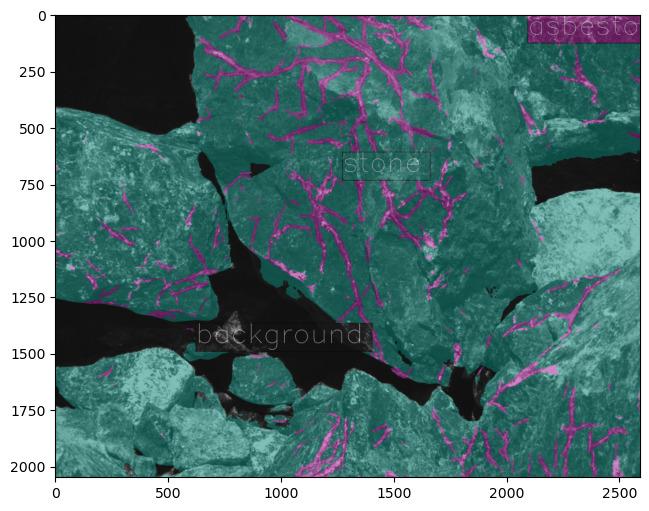

In [18]:
img = mmcv.imread('asbestos/images/'+test_image+'.bmp')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result,out_file='work_dirs_segformer/'+test_image+'.png',show=False)
plt.imshow(mmcv.bgr2rgb(vis_result))